### XGBoost Predictive Analysis

In [1]:
%pip install pandas
%pip install yfinance
%pip install scikit-learn
%pip install projectpro
%pip install plotly
%pip install --upgrade nbformat

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

import yfinance as yf

import keras
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import os 
import math

import plotly.express as px

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from keras.layers import LSTM, SimpleRNN
from keras.models import Sequential
from keras.layers import Dense

from xgboost import XGBRegressor

from itertools import cycle

from projectpro import model_snapshot, checkpoint

In [3]:
keras.backend.set_image_data_format("channels_last")
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
yf.pdr_override()
%matplotlib inline

In [4]:
now = datetime.now() 
dataset = yf.download('NVDA', now - relativedelta(years=4), datetime(2024, 2, 23))
long_dataset = yf.download('NVDA', now - relativedelta(years=10), datetime(2024, 2, 23))
print(dataset.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-02-26  65.514999  68.862503  65.500000  66.912498  66.652046   74773200
2020-02-27  63.724998  66.750000  62.222500  63.150002  62.941818   90641600
2020-02-28  60.615002  68.114998  60.447498  67.517502  67.294922  113325200
2020-03-02  69.224998  69.397499  65.250000  69.107498  68.879669   89074400
2020-03-03  69.667503  70.267502  65.614998  66.472504  66.253365   65279200


In [5]:
print(f"Shape of data: {dataset.shape}")

print("Starting date: ",dataset.iloc[0][0])
print("Ending date: ", dataset.iloc[-1][0])
print("Duration: ", dataset.iloc[-1][0]-dataset.iloc[0][0])

print(dataset.columns)
dataset = dataset.reset_index()
long_dataset = long_dataset.reset_index()
print(dataset.columns)

Shape of data: (1005, 6)
Starting date:  65.51499938964844
Ending date:  750.25
Duration:  684.7350006103516
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [6]:
closedf = dataset[['Date','Close']]
closedf = closedf[closedf['Date'] > '2018-09-13']
close_stock = closedf.copy()
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))

print(closedf.shape)

(1005, 1)


In [7]:
training_size=int(len(closedf))-14
# training_size=int(len(closedf)*0.7)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (991, 1)
test_data:  (14, 1)


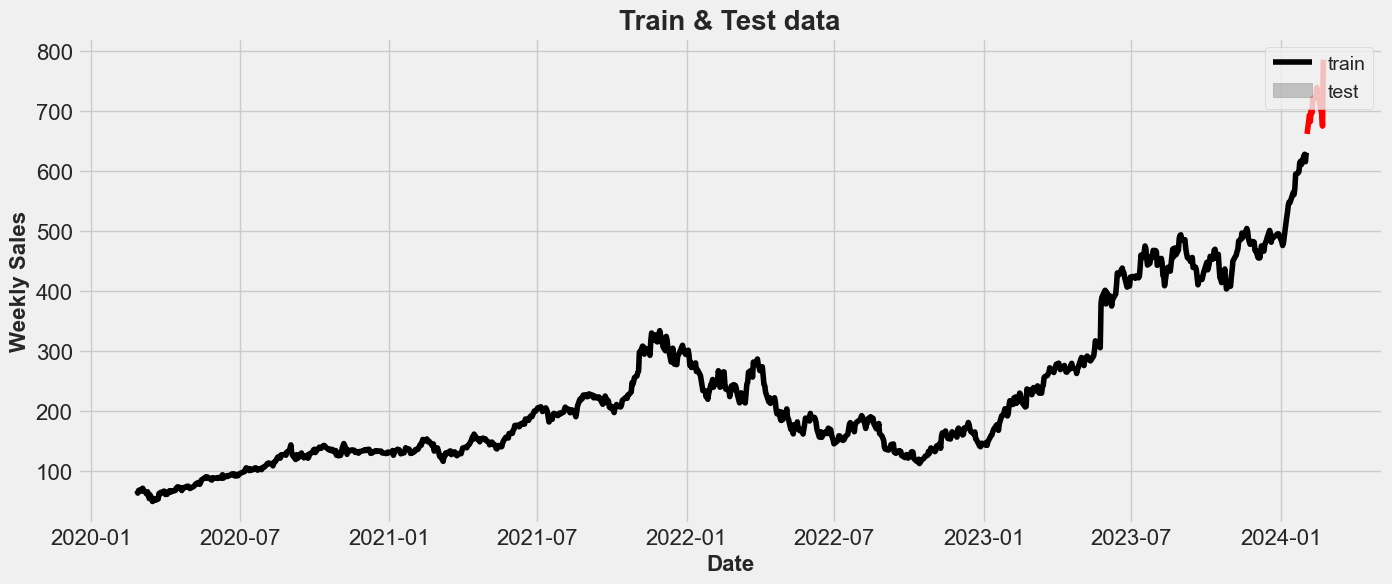

In [8]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = close_stock['Date'][:training_size], y = close_stock['Close'][:training_size], color = 'black')
sns.lineplot(x = close_stock['Date'][training_size:], y = close_stock['Close'][training_size:], color = 'red')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [9]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
def evaluate_model(y_true, y_pred):
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)

    # Calculate R-squared (R2) Score
    r2 = r2_score(y_true, y_pred)

    # Print the results
    print(f"Mean Squared Error (MSE): {mse:.5f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.5f}")
    print(f"Mean Absolute Error (MAE): {mae:.5f}")
    print(f"R-squared (R2) Score: {r2:.5f}")

In [11]:
time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)


X_train:  (989, 1)
y_train:  (989,)
X_test:  (12, 1)
y_test (12,)


In [12]:
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Testing data set 1-day at a time WITHOUT re-training model

In [13]:
pred = np.array([])
for i in range(0,12):
    predictions = my_model.predict([X_test[i]])
    pred = np.append(pred, predictions)
    Mas = mean_absolute_error([y_test[i]], predictions)
    Rmse = math.sqrt(mean_squared_error([y_test[i]], predictions))
    print(f"Day {i} Mean Absolute Error - MAE : {str(Mas)}, Root Mean squared Error - RMSE : {str(Rmse)}")

evaluate_model(y_test, pred)

Day 0 Mean Absolute Error - MAE : 0.10161056592155016, Root Mean squared Error - RMSE : 0.10161056592155016
Day 1 Mean Absolute Error - MAE : 0.08654832498204412, Root Mean squared Error - RMSE : 0.08654832498204412
Day 2 Mean Absolute Error - MAE : 0.11202777519437512, Root Mean squared Error - RMSE : 0.11202777519437512
Day 3 Mean Absolute Error - MAE : 0.10580729242969522, Root Mean squared Error - RMSE : 0.10580729242969522
Day 4 Mean Absolute Error - MAE : 0.13965317134587474, Root Mean squared Error - RMSE : 0.13965317134587474
Day 5 Mean Absolute Error - MAE : 0.14121502739098912, Root Mean squared Error - RMSE : 0.14121502739098912
Day 6 Mean Absolute Error - MAE : 0.13958527897811568, Root Mean squared Error - RMSE : 0.13958527897811568
Day 7 Mean Absolute Error - MAE : 0.1636521700370711, Root Mean squared Error - RMSE : 0.1636521700370711
Day 8 Mean Absolute Error - MAE : 0.14678361079051971, Root Mean squared Error - RMSE : 0.14678361079051971
Day 9 Mean Absolute Error - MA

Testing data set 1-day at a time WITH re-training model

In [14]:
X_train_copy = X_train.copy()
y_train_copy = y_train.copy()

pred = np.array([])
for i in range(0,12):
    # Training model up to current day
    my_model = XGBRegressor(n_estimators=1000)
    my_model.fit(X_train_copy, y_train_copy, verbose=False)
    predictions = my_model.predict([X_test[i]])
    pred = np.append(pred, predictions)
    
    # Calculating error measures
    Mas = mean_absolute_error([y_test[i]], predictions)
    Rmse = math.sqrt(mean_squared_error([y_test[i]], predictions))
    print(f"Day {i} Mean Absolute Error - MAE : {str(Mas)}, Root Mean squared Error - RMSE : {str(Rmse)}")
    
    x_add = np.array(X_test[i])
    y_add = np.array(y_test[i])
    
    X_train_copy = np.concatenate((X_train_copy, [x_add]), axis=0)
    y_train_copy = np.concatenate((y_train_copy, [y_add]), axis=0)

    
evaluate_model(y_test, pred)

Day 0 Mean Absolute Error - MAE : 0.10161056592155016, Root Mean squared Error - RMSE : 0.10161056592155016
Day 1 Mean Absolute Error - MAE : 0.06783616201054754, Root Mean squared Error - RMSE : 0.06783616201054754
Day 2 Mean Absolute Error - MAE : 0.07540155544492444, Root Mean squared Error - RMSE : 0.07540155544492444
Day 3 Mean Absolute Error - MAE : 0.04456399676013956, Root Mean squared Error - RMSE : 0.04456399676013956
Day 4 Mean Absolute Error - MAE : 0.059718753144428205, Root Mean squared Error - RMSE : 0.059718753144428205
Day 5 Mean Absolute Error - MAE : 0.032528341828855334, Root Mean squared Error - RMSE : 0.032528341828855334
Day 6 Mean Absolute Error - MAE : 0.022917948713070513, Root Mean squared Error - RMSE : 0.022917948713070513
Day 7 Mean Absolute Error - MAE : 0.04156701598052204, Root Mean squared Error - RMSE : 0.04156701598052204
Day 8 Mean Absolute Error - MAE : 0.009182294815330505, Root Mean squared Error - RMSE : 0.009182294815330505
Day 9 Mean Absolute 

In [15]:
train_predict=my_model.predict(X_train)
test_predict=my_model.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (989, 1)
Test data prediction: (12, 1)


(989, 1)


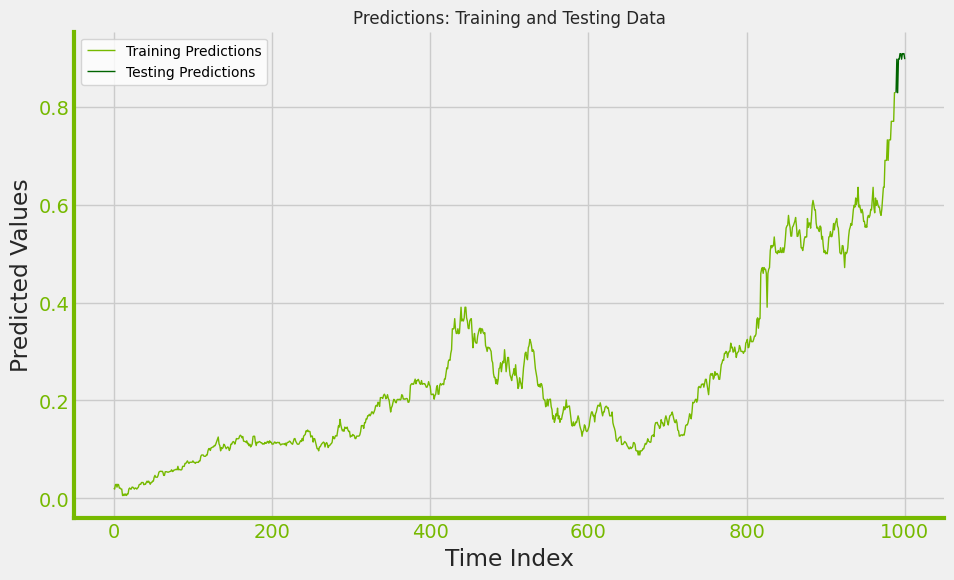

In [16]:
# Creating an index for the total dataset
from matplotlib import style

total_length = 989 + 12  # Adjust this if the total length differs
time_index = np.arange(total_length)

# Splitting the index into training and testing periods
train_index = time_index[:989]
test_index = time_index[989:]
print(f"{train_predict.shape}")
plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
plt.plot(train_index, train_predict, label='Training Predictions', color='#76B900', linewidth=1)
plt.plot(test_index, test_predict, label='Testing Predictions', color='darkgreen',linewidth=1)

style.use('default')

# Adding labels and title for clarity
plt.xlabel('Time Index')
plt.ylabel('Predicted Values')
plt.title('Predictions: Training and Testing Data')
plt.legend()
plt.gca().spines['top'].set_color('none')  # Remove the top border
plt.gca().spines['right'].set_color('none')  # Remove the right border
plt.gca().spines['left'].set_color('#76B900')  # Set left border to white
plt.gca().spines['bottom'].set_color('#76B900')  # Set bottom border to white
plt.tick_params(axis='x', colors='#76B900')  # Set x-axis tick colors to white
plt.tick_params(axis='y', colors='#76B900')  # Set y-axis tick colors to white

plt.show()

In [17]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Close price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1005, 1)
Test predicted data:  (1005, 1)


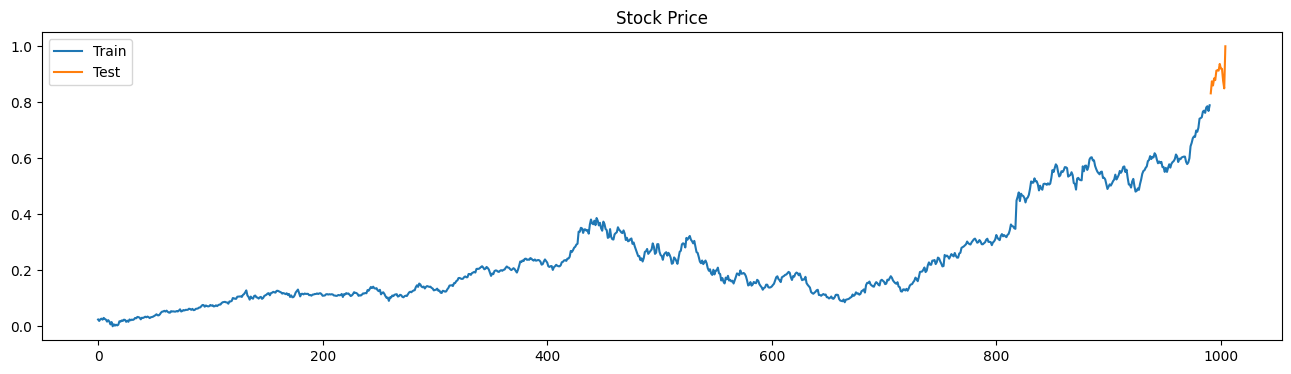

In [18]:
def train_test_plot(train_set, test_set):
    plt.figure(figsize=(16, 4))
    plt.plot(train_set, label=f"Train")
    plt.plot(range(len(train_set), len(train_set) + len(test_set)), test_set, label=f"Test")
    plt.legend()
    plt.title("Stock Price")
    plt.show()
    
train_test_plot(train_data, test_data)

In [19]:
closedf = long_dataset[['Date','Close']]
close_stock = closedf.copy()
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))

training_size=int(len(closedf)*0.7)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape[0])
print("test_data: ", test_data.shape)

train_data:  1760
test_data:  (755, 1)


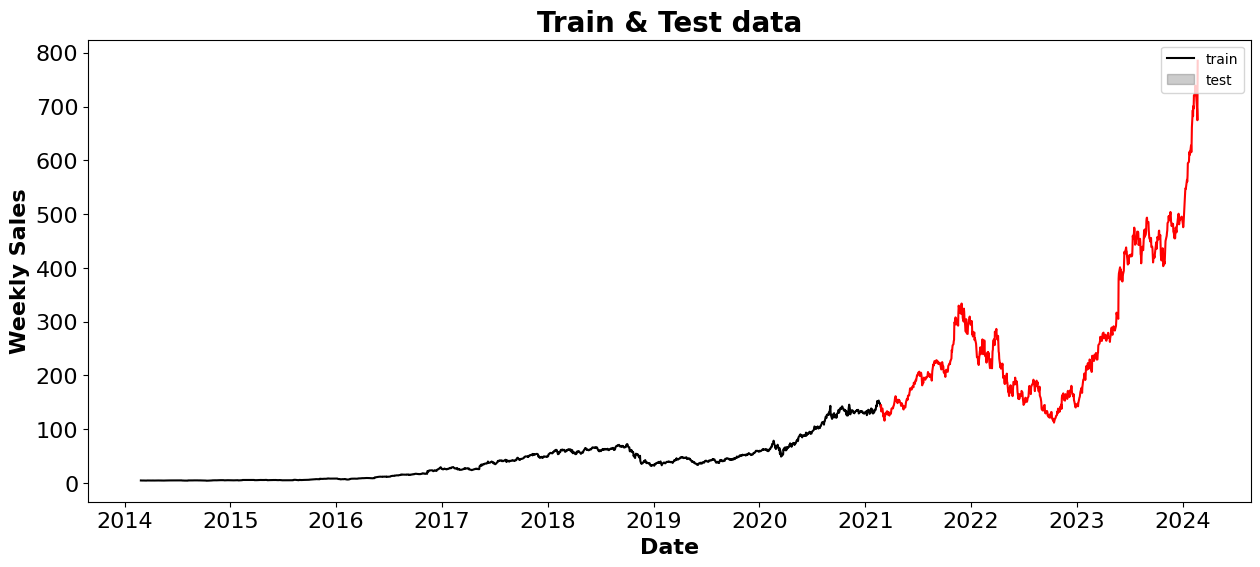

In [20]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = close_stock['Date'][:train_data.shape[0]], y = close_stock['Close'][:train_data.shape[0]], color = 'black')
sns.lineplot(x = close_stock['Date'][train_data.shape[0]:], y = close_stock['Close'][train_data.shape[0]:], color = 'red')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [21]:
time_step = 21
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1738, 21)
y_train:  (1738,)
X_test:  (733, 21)
y_test (733,)


In [22]:
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train, y_train, verbose=False)
predictions = my_model.predict(X_test)
evaluate_model(y_test, predictions)

Mean Squared Error (MSE): 0.05689
Root Mean Squared Error (RMSE): 0.23851
Mean Absolute Error (MAE): 0.16782
R-squared (R2) Score: -0.92959


In [23]:
train_predict=my_model.predict(X_train)
test_predict=my_model.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (1738, 1)
Test data prediction: (733, 1)


In [24]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [25]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Close price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2515, 1)
Test predicted data:  (2515, 1)
